In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Bidirectional,Flatten,Dropout
from datetime import datetime
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from xgboost import XGBClassifier
from joblib import dump
from joblib import load

from sklearn.metrics import roc_auc_score

# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

def plot_pr_curve(test_y, model_probs):
# calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    print('No Skill %.3f' % no_skill)
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = metrics.precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label='LSTM')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.ylim([0,1])
    plt.show()
    
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def parser(x):
	return datetime.strptime(x, '%m/%d/%Y')

# smaller model
def create_smaller():
	# create model
	model = Sequential()
	model.add(Dense(30, input_dim=24, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

def create_model(optimizer='rmsprop', init='glorot_uniform'):
	# create model
	model = Sequential()
	model.add(Dense(100, input_dim=21, kernel_initializer=init, activation='relu'))
	model.add(Dense(50, kernel_initializer=init, activation='relu'))
	model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap="Blues", annot=annot, fmt='', ax=ax)

In [2]:
df = pd.read_csv('Combined.csv', header=0, parse_dates=[0], squeeze=True, date_parser=parser)

In [3]:
df = df[df['Event Date'].dt.year < 2020]

In [4]:
df['Week_Number'] = df['Event Date'].dt.week

<ipython-input-4-87e035a3652c>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week_Number'] = df['Event Date'].dt.week


In [5]:
df['Week_Number']=df['Event Date'].dt.year.astype(str) + df['Week_Number'].astype(str).str.zfill(2)

In [6]:
df = df.groupby(['Week_Number']).sum()

In [7]:
df.tail(10)

,ADMN,COMP,CS,GEN,OT,SICK,VAC,CallBacks
Week_Number,,,,,,,,
201943,0.0,0.0,2376,492.0,0.0,2358.0,4113.00,9.42
201944,0.0,29.0,2712,582.0,0.0,1968.0,4276.00,22.31
201945,0.0,2.0,2520,888.0,0.0,1999.0,3904.00,14.46
201946,0.0,0.0,2592,864.0,0.0,1865.0,3968.31,0.00
201947,0.0,14.0,2352,248.0,0.0,2038.0,4206.00,9.30
201948,0.0,12.0,2808,204.0,0.0,2168.0,5337.00,19.31
201949,0.0,36.0,2568,616.0,0.0,2667.0,3544.67,23.37
201950,0.0,26.0,2808,565.0,0.0,2438.0,3732.00,13.92
201951,0.0,64.0,2616,472.0,0.0,2326.0,4466.00,10.76


<AxesSubplot:xlabel='Week_Number'>

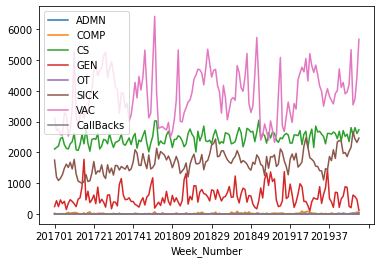

In [8]:
df.plot()

In [9]:
series = df.copy()

In [10]:
series['CallBacks'].to_csv('week.csv')

<AxesSubplot:>

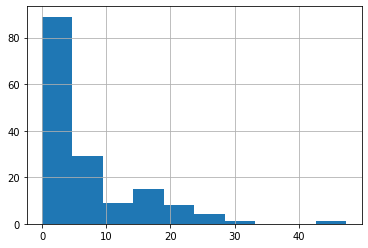

In [11]:
series['CallBacks'].hist()

In [13]:
# series['CB_TOTAL'][series['CB_TOTAL']>0] = 1
# series['CB_TOTAL'][series['CB_TOTAL']<=0] = 0

In [12]:
values = series.values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
y = values[:,7]

In [13]:
X = values[:, :-1]
y[y>0] = 1
y[y<=0] = 0

# frame as supervised learning
into =3
reframed = series_to_supervised(X, into, 1)
col = len(reframed.columns)
# drop columns we don't want to predict
reframed.drop(reframed.columns[col-7:col], axis=1, inplace=True)
print(reframed.head())
# split into train and test sets
values = concatenate((reframed.values,y[into:].reshape(len(y[into:]),1)), axis=1)
print(values)
scaler = MinMaxScaler(feature_range=(0, 1))
print(values.shape)
values = scaler.fit_transform(values)
 
n_train_hours = round(len(values)*.65)
X = values[:, :-1]
y = values[:, -1]
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
resultmean = []
auc = []
# for i in range(50):
#     print(i)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)
#     # split into input and outputs
#     # train_X, train_y = train[:, :-1], train[:, -1]
#     # test_X, test_y = test[:, :-1], test[:, -1]
#     # reshape input to be 3D [samples, timesteps, features]
#     X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
#     X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
#     #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#     y_train = to_categorical(y_train)
#     y_test = to_categorical(y_test)
#     y_test = np.argmax(y_test, axis=1)
#     y_train = np.argmax(y_train, axis=1)
#     X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
#     X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
#     encoder = LabelEncoder()
#     encoder.fit(y_train)
#     encoded_Y = encoder.transform(y_train)
#     estimators = []
#     estimators.append(('standardize', StandardScaler()))
#     estimators.append(('mlp', KerasClassifier(build_fn=create_smaller,validation_split=10, epochs=50, batch_size=500, verbose=0)))
#     pipeline = Pipeline(estimators)
#     kfold = StratifiedKFold(n_splits=10, shuffle=True)
#     results = cross_val_score(pipeline, X_train, encoded_Y, cv=kfold)
#     resultmean.append(results.mean()*100)
#     pipeline.fit(X_train, encoded_Y)
#     yhat=pipeline.predict(X_test)
#     fpr, tpr, threshold = metrics.roc_curve(y_test,yhat)
#     roc_auc = metrics.auc(fpr, tpr)
#     auc.append(roc_auc)
#     plot_cm(y_test, yhat)
# pd.DataFrame(resultmean).hist()
# pd.DataFrame(auc).hist()

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3        0.0       27.0     2112.0      242.0        0.0     1752.0   
4        0.0        2.0     2160.0      432.0        0.0     1200.0   
5        0.0        5.0     2208.0      240.0        0.0     1088.0   
6        0.0       10.0     2448.0      458.0        0.0     1158.0   
7        0.0       15.0     2496.0      336.0        0.0     1278.0   

   var7(t-3)  var1(t-2)  var2(t-2)  var3(t-2)  ...  var5(t-2)  var6(t-2)  \
3     3119.0        0.0        2.0     2160.0  ...        0.0     1200.0   
4     2715.0        0.0        5.0     2208.0  ...        0.0     1088.0   
5     2768.0        0.0       10.0     2448.0  ...        0.0     1158.0   
6     2576.0        0.0       15.0     2496.0  ...        0.0     1278.0   
7     2568.0        0.0        0.0     2256.0  ...        0.0     1484.0   

   var7(t-2)  var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
3     2715.0        0.0        5.0     2208.0

In [14]:
split=round(len(X)-52)
X = values[:, :-1]
y = values[:, -1]
X_train= X[:split]
y_train= y[:split]
X_test=X[split:]
y_test=y[split:]

In [15]:
pd.DataFrame(y_test).to_csv('week.csv')

In [16]:
y_test

array([1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1.], dtype=float32)

In [17]:
y

array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [18]:
ros = RandomOverSampler(random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y)
X_train,y_train=ros.fit_resample(X_train, y_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_test = np.argmax(y_test, axis=1)
y_train = np.argmax(y_train, axis=1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))

In [19]:
y_test

array([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1])

In [20]:
len(y_train[y_train == 1])

64

In [21]:
X =  X.reshape((X.shape[0], 1, X.shape[1]))

In [22]:
X = X.reshape((X.shape[0], X.shape[2]))

In [23]:
np.save('data.npy', X_test)

In [24]:
X_test.shape

(52, 21)

In [25]:
model = XGBClassifier()
model.fit(X_train, y_train)

/home/bharris/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:43:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=96, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
yhat = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test,yhat)
roc_auc = metrics.auc(fpr, tpr)

In [41]:
y_test[0]

1

In [42]:
yhat.round()

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1])

In [43]:
roc_auc

0.6166666666666666

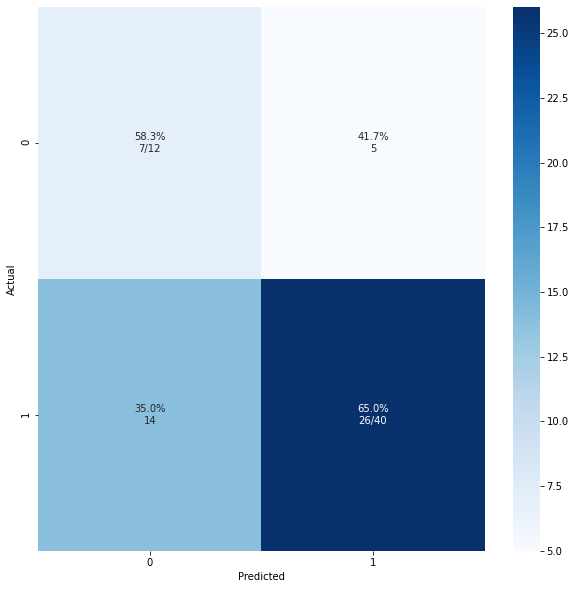

In [44]:
plot_cm(y_test, yhat)

In [45]:
model.save_model('model.bst')

In [38]:
dump(model, "best.h5")

['best.h5']

In [39]:
np.array(np.random.randint(2)).reshape(1,1,1)

array([[[0]]])

In [40]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [41]:
from keras.models import load_model

In [43]:
model=load('best.h5')

In [76]:
X_test.shape[1]

21

In [70]:
yhat = model.predict(X_test[0].reshape(1,21)
fpr, tpr, threshold = metrics.roc_curve(y_test[0],int(yhat))
roc_auc = metrics.auc(fpr, tpr)

SyntaxError: invalid syntax (<ipython-input-70-51d16ef96830>, line 2)

In [46]:
yhat = model.predict(X_test).round()

In [72]:
yhat

array([1])

In [48]:
roc_auc

0.6166666666666666